# DeepSphere using SHREC17 dataset
### Benchmark with Cohen method S2CNN[[1]](http://arxiv.org/abs/1801.10130) and Esteves method[[2]](http://arxiv.org/abs/1711.06721)
Multi-class classification of 3D objects, using the interesting property of rotation equivariance.

The 3D objects are projected on a unit sphere.
Cohen and Esteves use equiangular sampling, while our method use a HEAlpix sampling

Several features are collected:
* projection ray length (from sphere border to intersection [0, 2])
* cos/sin with surface normal
* same features using the convex hull of the 3D object

## 0.1 Load libs

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import shutil
import sys

os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # change to chosen GPU to use, nothing if work on CPU

import numpy as np
import time
import matplotlib.pyplot as plt
import healpy as hp

In [3]:
from deepsphere import models, experiment_helper, plot, utils
from deepsphere.data import LabeledDatasetWithNoise, LabeledDataset
import hyperparameters

from SHREC17.load_shrec import fix_dataset, Shrec17Dataset, Shrec17DatasetCache

## 0.2 Define parameters

In [9]:
bw = 64
experiment = 'equiangular'
experiment_type = 'CNN' # 'FCN'
ename = '_'+experiment_type
datapath = '../data/shrec17/' # localisation of the .obj files

In [7]:
sigma_noise = 0
noise_dataset = True    # use perturbed dataset (Cohen and Esteves do the same)
augmentation = 1        # number of element per file (1 = no augmentation of dataset)

## 1 Load dataset

In [12]:
# if datasets are already downloaded but not preprocessed
fix = False
if fix:
    fix_dataset(datapath+'val_perturbed')
    fix_dataset(datapath+'test_perturbed')

download dataset if True, preprocess data and store it in npy files, and load it in a dataset object

In [21]:
12*64**2

49152

In [19]:
(49512/12)**0.5

64.2339474110069

In [26]:
download = False
train_dataset = Shrec17Dataset(datapath, 'train', perturbed=noise_dataset, download=download, nside=bw, 
                                    augmentation=augmentation, nfile=None, experiment = experiment)


31364it [01:04, 485.07it/s]


In [27]:
val_dataset = Shrec17Dataset(datapath, 'val', perturbed=noise_dataset, download=download, nside=bw, 
                                 augmentation=augmentation, nfile=None, experiment = experiment)

5133it [00:09, 534.14it/s]


## 1.1 Preprocess the dataset

Shuffle the training dataset and print the classes distribution

Number of elements / class


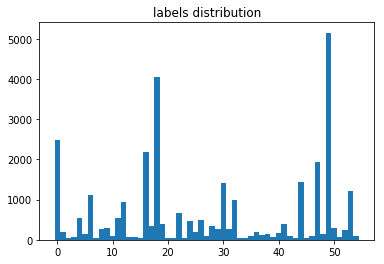

In [28]:
# Not necessary if datasetCache is used
x_train, labels_train, ids_train = train_dataset.return_data(train=True, train_ratio=1.)

In [29]:
nclass = train_dataset.nclass
num_elem = train_dataset.N
print('number of class:',nclass,'\nnumber of elements:',num_elem,'\nfirst id:',ids_train[0])

number of class: 55 
number of elements: 31364 
first id: 000523


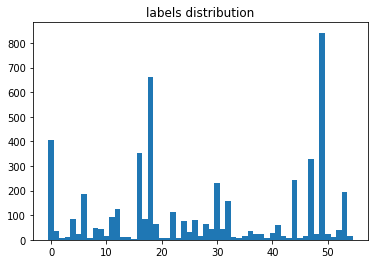

In [30]:
x_val, labels_val, ids_val = val_dataset.return_data(train=False)

#### Plot sphere images

Show what the projection looks like for the first two features

In [31]:
im1 = x_train[0,:,0]
im0003 = train_dataset.data[0,:,0]
im1_norm = x_train[0,:,1]
im0003_norm = train_dataset.data[0,:,1]
cm = plt.cm.RdBu_r
cm.set_under('w')
cmin = np.min(x_train[:,:,0])
cmax = np.max(x_train[:,:,0])
cmin_norm = np.min(x_train[:,:,1])
cmax_norm = np.max(x_train[:,:,1])

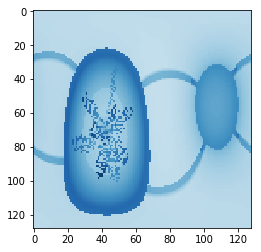

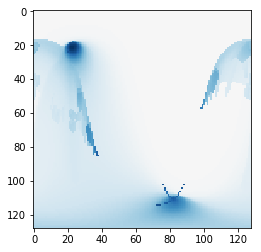

In [35]:
plt.imshow(im1.reshape((2*bw,2*bw)), cmap=cm, vmin = cmin, vmax = cmax)
plt.figure()
plt.imshow(im0003.reshape((2*bw,2*bw)), cmap=cm, vmin = cmin, vmax = cmax)

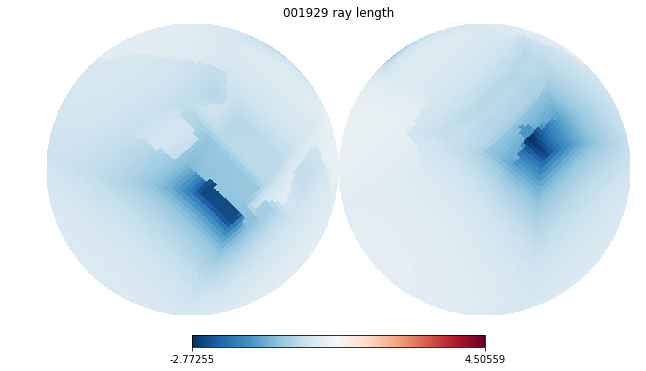

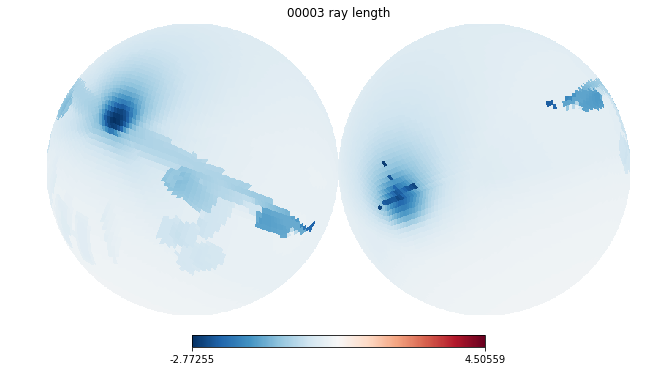

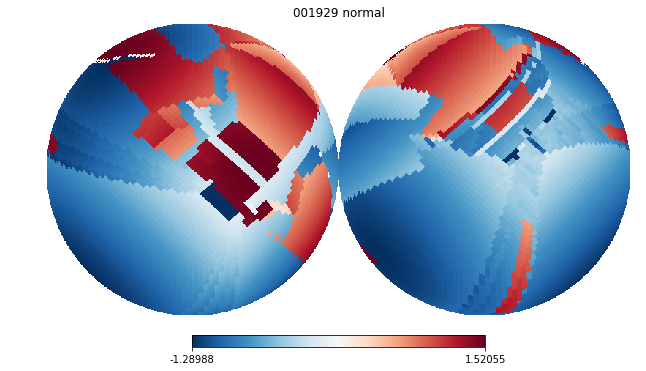

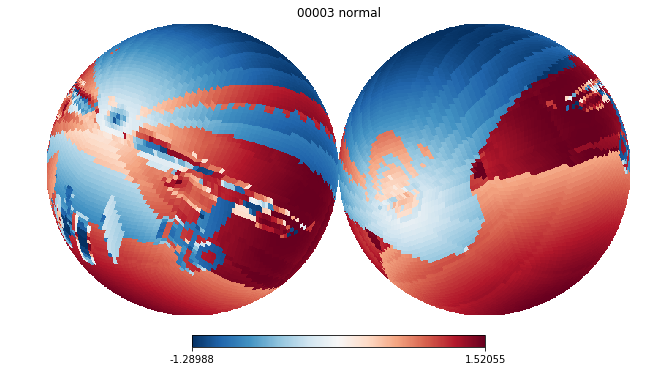

In [16]:
# hp.orthview(im1, title=ids_train[0]+" ray length", nest=True, cmap=cm, min=cmin, max=cmax)
# hp.orthview(im0003, rot=(90,90,290), title='00003 ray length', nest=True, flip='geo', cmap=cm, min=cmin, max=cmax)
# hp.orthview(im1_norm, title=ids_train[0]+" normal", nest=True, cmap=cm, min=cmin_norm, max=cmax_norm)
# hp.orthview(im0003_norm, rot=(90,90,290), title='00003 normal', nest=True, flip='geo', cmap=cm, min=cmin_norm, max=cmax_norm)

## 2 Classification using DeepSphere

Use of the Dataset object used for other DeepSphere experiments

In [36]:
training = LabeledDataset(x_train, labels_train)
validation = LabeledDataset(x_val, labels_val)

In [37]:
EXP_NAME = 'shrec17_equiangular_SGD_max_bw_{}bw{}'.format(bw, ename)
#EXP_NAME = "shrec17_40sim_32sides_0noise_FCN"
#EXP_NAME = 'plop'

Load model with hyperparameters chosen.
For each experiment, a new EXP_NAME is chosen, and new hyperparameters are store.
All informations are present 'DeepSphere/Shrec17/experiments.md'
The fastest way to reproduce an experiment is to revert to the commit of the experiment to load the correct files and notebook

Adding a layer in the fully connected can be beneficial

In [39]:
params = hyperparameters.get_params_shrec17_equiangular(num_elem, EXP_NAME, nclass, architecture=experiment_type)
model = models.deepsphere(**params)

bandwidth: 64
#pixels: [16384, 1024, 400]
#samples per batch: 32
=> #pixels per batch (input): 524,288
=> #pixels for training (input): 51,386,777,600
Learning rate will start at 5.0e-01 and finish at 5.0e-01.
NN architecture
  input: M_0 = 16384
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 16384 * 100 / 16 = 102400
    weights: F_0 * F_1 * K_1 = 6 * 100 * 64 = 38400
    biases: F_1 = 100
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 1024 * 100 / 1 = 102400
    weights: F_1 * F_2 * K_2 = 100 * 100 * 16 = 160000
    biases: F_2 = 100
    batch normalization
  Statistical layer: mean
    representation: 1 * 100 = 100
  layer 3: logits (softmax)
    representation: M_3 = 55
    weights: M_2 * M_3 = 100 * 55 = 5500


In [40]:
shutil.rmtree('summaries/{}/'.format(EXP_NAME), ignore_errors=True)
shutil.rmtree('checkpoints/{}/'.format(EXP_NAME), ignore_errors=True)

Find a correct learning rate

In [18]:
backup = params.copy()

params, learning_rate = utils.test_learning_rates(params, training.N, 1e-6, 1e-1, num_epochs=20)

shutil.rmtree('summaries/{}/'.format(params['dir_name']), ignore_errors=True)
shutil.rmtree('checkpoints/{}/'.format(params['dir_name']), ignore_errors=True)

model = models.deepsphere(**params)
_, loss_validation, _, _ = model.fit(training, validation)

params.update(backup)

plt.semilogx(learning_rate, loss_validation, '.-')

NN architecture
  input: M_0 = 12288
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 12288 * 100 / 16 = 76800
    weights: F_0 * F_1 * K_1 = 6 * 100 * 56 = 33600
    biases: F_1 = 100
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 768 * 100 / 4 = 19200
    weights: F_1 * F_2 * K_2 = 100 * 100 * 13 = 130000
    biases: F_2 = 100
    batch normalization
  Statistical layer: mean
    representation: 1 * 100 = 100
  layer 3: logits (softmax)
    representation: M_3 = 55
    weights: M_2 * M_3 = 100 * 55 = 5500
step 1470 / 19602 (epoch 1.50 / 20):
  learning_rate = 5.62e-06, training loss = 4.35e+00


/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 0.45 (23 / 5133), f1 (weighted): 0.28, loss: 4.20e+00
  CPU time: 247s, wall time: 976s, perf_time: 0.62s
step 2940 / 19602 (epoch 3.00 / 20):
  learning_rate = 3.16e-05, training loss = 3.72e+00
  validation accuracy: 3.37 (173 / 5133), f1 (weighted): 2.86, loss: 3.97e+00
  CPU time: 470s, wall time: 1889s, perf_time: 0.56s
step 4410 / 19602 (epoch 4.50 / 20):
  learning_rate = 1.78e-04, training loss = 3.29e+00
  validation accuracy: 31.09 (1596 / 5133), f1 (weighted): 19.99, loss: 3.17e+00
  CPU time: 686s, wall time: 2769s, perf_time: 0.57s
step 5880 / 19602 (epoch 6.00 / 20):
  learning_rate = 9.98e-04, training loss = 2.18e+00
  validation accuracy: 45.22 (2321 / 5133), f1 (weighted): 33.98, loss: 2.36e+00
  CPU time: 901s, wall time: 3648s, perf_time: 0.56s
step 7350 / 19602 (epoch 7.50 / 20):
  learning_rate = 5.61e-03, training loss = 1.69e+00
  validation accuracy: 57.72 (2963 / 5133), f1 (weighted): 50.28, loss: 1.77e+00
  CPU time: 1118s, wall time: 4

KeyboardInterrupt: 

0.9 seems to be a good learning rate for SGD with current parameters

## 2.2 Train Network

In [41]:
print("the number of parameters in the model is: {:,}".format(model.get_nbr_var()))

conv1/weights:0
conv1/bias:0
conv2/weights:0
conv2/bias:0
logits/weights:0
the number of parameters in the model is: 204,100


In [ ]:
accuracy_validation, loss_validation, loss_training, t_step = model.fit(training, validation, use_tf_dataset=False)

step 490 / 98012 (epoch 0.50 / 100):
  learning_rate = 5.00e-01, training loss = 4.79e-01


/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 62.19 (3192 / 5133), f1 (weighted): 57.88, loss: 1.48e+00
  CPU time: 183s, wall time: 567s, perf_time: 1.00s


In [ ]:
plot.plot_loss(loss_training, loss_validation, t_step, params['eval_frequency'])

Remarks

In [31]:
model.evaluate(x_train, labels_train)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_SGD_max_K5_aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_SGD_max_K5_aug_32sides_CNN/model-69090


('accuracy: 87.16 (82014 / 94092), f1 (weighted): 87.11, loss: 4.21e-01\nCPU time: 170s, wall time: 174s',
 87.16362708838157,
 87.10843320820175,
 0.4211443305808671)

In [ ]:
#predictions, loss = model.predict(x_val, labels_val)

In [32]:
model.evaluate(x_val, labels_val)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_SGD_max_K5_aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_SGD_max_K5_aug_32sides_CNN/model-69090


/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


('accuracy: 78.75 (12127 / 15399), f1 (weighted): 78.28, loss: 8.73e-01\nCPU time: 29s, wall time: 27s',
 78.75186700435093,
 78.28435398225768,
 0.8728966263904069)

In [12]:
repeat = 3

In [38]:
probabilities = model.probs(x_val, nclass)
if repeat>1:
    probabilities = probabilities.reshape((-1,repeat,nclass))
    probabilities = probabilities.mean(axis=1)
    ids_val = ids_val[::repeat]
predictions = np.argmax(probabilities, axis=1)

In [ ]:
#predictions = predictions.astype(np.int)

In [39]:
# for every file, find every object with the same class, sorted by most relevance
os.makedirs(os.path.join(datapath,'results_SGD_aug/val_perturbed'), exist_ok=True)
for i,_id in enumerate(ids_val):
    idfile = os.path.join(datapath,'results_SGD_aug/val_perturbed',_id)
    # predictions batchxclass
    # pred_class batch == predictions
    retrieved = [(probabilities[j, predictions[j]], ids_val[j]) for j in range(len(ids_val)) if predictions[j] == predictions[i]]
    retrieved = sorted(retrieved, reverse=True)
    retrieved = [i for _, i in retrieved]
    with open(idfile, "w") as f:
        f.write("\n".join(retrieved))

In [40]:
del x_train, x_val, labels_train, labels_val

NaN appears if remove i==j case

## test network

In [10]:
download = False

In [11]:
test_dataset = shrecDataset(datapath, 'test', perturbed=noise_dataset, download=download, nside=Nside, augmentation=augmentation, nfile=None)

10265it [00:29, 343.80it/s]


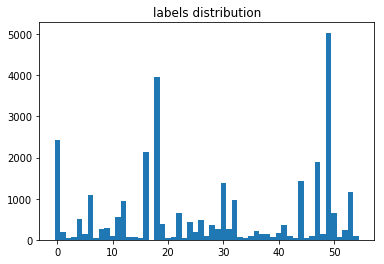

In [12]:
x_test, labels_test, ids_test = test_dataset.return_data(train=False)

In [41]:
model.evaluate(x_test, labels_test)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_SGD_max_K5_aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_SGD_max_K5_aug_32sides_CNN/model-69090


/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


('accuracy: 75.87 (23365 / 30795), f1 (weighted): 75.83, loss: 9.96e-01\nCPU time: 61s, wall time: 58s',
 75.87270660821562,
 75.83077448589687,
 0.9964468322978582)

In [ ]:
#predictions = model.predict(x_test)

In [14]:
repeat = 3

In [15]:
probabilities = model.probs(x_test, nclass)
#probabilities = np.log(probabilities)
if repeat>1:
    probabilities = probabilities.reshape((-1,repeat,nclass))
    probabilities = probabilities.mean(axis=1)
    ids_test = ids_test[::repeat]
predictions = np.argmax(probabilities, axis=1)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_SGD_max_K5_aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_SGD_max_K5_aug_32sides_CNN/model-69090


In [ ]:
#predictions = predictions.astype(np.int)

write to file

In [16]:
# for every file, find every object with the same class, sorted by most relevance
os.makedirs(os.path.join(datapath,'results_SGD_aug/test_perturbed'), exist_ok=True)
for i, _id in enumerate(ids_test):
    idfile = os.path.join(datapath,'results_SGD_aug/test_perturbed',_id)
    # predictions batchxclass
    # pred_class batch == predictions
    retrieved = [(probabilities[j, predictions[j]], ids_test[j]) for j in range(len(ids_test)) if predictions[j] == predictions[i]]
    retrieved = sorted(retrieved, reverse=True)
    retrieved = [i for _, i in retrieved]
    with open(idfile, "w") as f:
        f.write("\n".join(retrieved))

Why not working?

In [44]:
def _print_histogram(nclass, labels_train, labels_val=None):
    if labels_train is None:
        return
    import matplotlib.pyplot as plt
    from collections import Counter
    hist_train=Counter(labels_train)
#         for i in range(self.nclass):
#             hist_train.append(np.sum(labels_train == i))
    labels, values = zip(*hist_train.items())
    indexes = np.asarray(labels)
#     miss = set(indexes) - set(labels)
#     if len(miss) is not 0:
#         hist_train.update({elem:0 for elem in miss})
#     labels, values = zip(*hist_train.items())
    width = 1
    plt.bar(labels, values, width)
    plt.title("labels distribution")
    #plt.xticks(indexes + width * 0.5, labels)
    if labels_val is not None:
        hist_val=Counter(labels_val)
        plt.figure()
        labels, values = zip(*hist_val.items())
        indexes = np.asarray(labels)
        width = 1
        plt.bar(indexes, values, width)
        plt.title("validation labels distribution")
    plt.show()

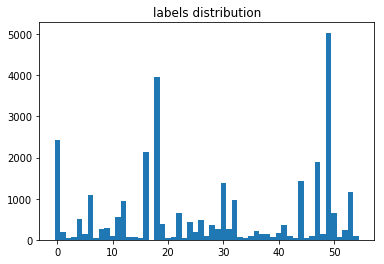

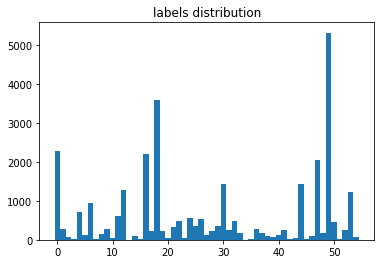

In [45]:
_print_histogram(55, labels_test)
_print_histogram(55, predictions)

In [25]:
del test_dataset
del train_dataset
del val_dataset

In [22]:
import tensorflow as tf
tf.reset_default_graph()

### Build Equiangular weight matrix

In [5]:
import os
import sys
import hashlib
import zipfile

import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import healpy as hp

In [129]:
def equiangular_weightmatrix(bw=64, indexes=None, dtype=np.float32):
    # define a way to read the grid
    if indexes is None:
        indexes = range((2*bw)**2)
    npix = len(indexes)  # Number of pixels.
    
    # Find a mean to take only indexes from grid
    beta = np.arange(2 * bw) * np.pi / (2. * bw)  # Driscoll-Heally
    alpha = np.arange(2 * bw) * np.pi / bw
    theta, phi = np.meshgrid(*(beta, alpha),indexing='ij')
    ct = np.cos(theta)
    st = np.sin(theta)
    cp = np.cos(phi)
    sp = np.sin(phi)
    x = st * cp
    y = st * sp
    z = ct
    coords = np.vstack([x.flatten(), y.flatten(), z.flatten()]).transpose() 
    coords = np.asarray(coords, dtype=dtype)
    
    
    def south(x, bw):
        if x >= (2*bw)*(2*bw-1):
            return north((x+bw)%(2*bw)+(2*bw)*(2*bw),bw)
        else:
            return x + 2*bw
        
    def north(x, bw):
        if x < 2*bw:
            return south((x+bw)%(2*bw),bw)
        else:
            return x - 2*bw
        
    def west(x, bw):
        if x%(2*bw)==0:
            x += 2*bw
        return x -1
    
    def east(x, bw):
        if x%(2*bw)==2*bw-1:
            x -= 2*bw
        return x + 1
        
    neighbors = []
    col_index=[]
    for ind in indexes:
        # first line is the same point, so is connected to all points of second line
        if ind < 2* bw:
            neighbor = np.arange(2*bw)+2*bw
        elif ind < 4*bw:
            neighbor = [south(west(ind,bw),bw), west(ind,bw), east(ind,bw), south(east(ind,bw),bw), south(ind,bw)]
            neighbor += list(range(2*bw))
            #print(neighbor)
        else:
            neighbor = [south(west(ind,bw),bw), west(ind,bw), north(west(ind,bw), bw), north(ind,bw), 
                        north(east(ind,bw),bw), east(ind,bw), south(east(ind,bw),bw), south(ind,bw)]
        neighbors.append(neighbor)
        col_index += list(neighbor)
    # neighbors = np.asarray(neighbors)
    col_index = np.asarray(col_index)
    
    #col_index = neighbors.reshape((-1))
    row_index = np.hstack([np.repeat(indexes[:2*bw], 2*bw), np.repeat(indexes[2*bw:4*bw], 2*bw+5), 
                          np.repeat(indexes[4*bw:], 8)])
    
    distances = np.sum((coords[row_index] - coords[col_index])**2, axis=1)
    # slower: np.linalg.norm(coords[row_index] - coords[col_index], axis=1)**2

    # Compute similarities / edge weights.
    kernel_width = np.mean(distances)
    weights = np.exp(-distances / (2 * kernel_width))

    # Similarity proposed by Renata & Pascal, ICCV 2017.
    # weights = 1 / distances

    # Build the sparse matrix.
    W = sparse.csr_matrix(
        (weights, (row_index, col_index)), shape=(npix, npix), dtype=dtype)
    
    return W

In [130]:
mat = equiangular_weightmatrix(4)

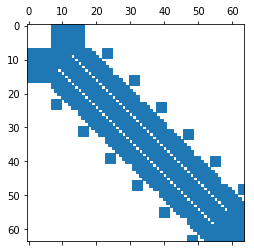

In [131]:
plt.spy(mat)

In [29]:
bw = 4
indexes = range((2*bw)**2)
np.asarray(indexes).reshape((-1, 2*bw))

array([[ 0,  1,  2,  3,  4,  5,  6,  7],
       [ 8,  9, 10, 11, 12, 13, 14, 15],
       [16, 17, 18, 19, 20, 21, 22, 23],
       [24, 25, 26, 27, 28, 29, 30, 31],
       [32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47],
       [48, 49, 50, 51, 52, 53, 54, 55],
       [56, 57, 58, 59, 60, 61, 62, 63]])

In [45]:
neighbors[:16]

array([[15, 14, 11, 12, 13, 10,  9,  8],
       [ 8, 15, 12, 13, 14, 11, 10,  9],
       [ 9,  8, 13, 14, 15, 12, 11, 10],
       [10,  9, 14, 15,  8, 13, 12, 11],
       [11, 10, 15,  8,  9, 14, 13, 12],
       [12, 11,  8,  9, 10, 15, 14, 13],
       [13, 12,  9, 10, 11,  8, 15, 14],
       [14, 13, 10, 11, 12,  9,  8, 15],
       [23, 15,  7,  0,  1,  9, 17, 16],
       [16,  8,  0,  1,  2, 10, 18, 17],
       [17,  9,  1,  2,  3, 11, 19, 18],
       [18, 10,  2,  3,  4, 12, 20, 19],
       [19, 11,  3,  4,  5, 13, 21, 20],
       [20, 12,  4,  5,  6, 14, 22, 21],
       [21, 13,  5,  6,  7, 15, 23, 22],
       [22, 14,  6,  7,  0,  8, 16, 23]])

In [2]:
from deepsphere.utils import *

In [133]:
build_laplacians([64, 32, 16, 8], indexes=None, use_4=False, sampling='equiangular')

([<16384x16384 sparse matrix of type '<class 'numpy.float32'>'
  	with 178816 stored elements in Compressed Sparse Row format>,
  <4096x4096 sparse matrix of type '<class 'numpy.float32'>'
  	with 44352 stored elements in Compressed Sparse Row format>,
  <1024x1024 sparse matrix of type '<class 'numpy.float32'>'
  	with 10912 stored elements in Compressed Sparse Row format>],
 [4, 4, 4])

In [139]:
G = equiangular_graph(bw=2)

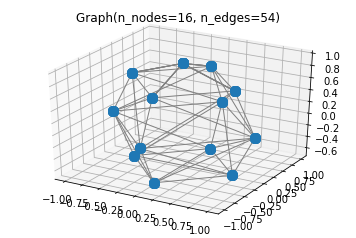

In [140]:
G.plot()